## 4. Analyse van vernieuwende programma's

In dit notebook gebruiken we percentuele verdeling van thema’s om te berekenen hoe “vernieuwend” de verkiezingsprogramma’s zijn. Schrijf je een verkiezingsprogramma vol over klimaatmaatregelen wanneer het bij de vorige verkiezingen vooral over economie ging? Dan is dat vernieuwender dan wanneer je steeds dezelfde thema’s aansnijdt. 

Concreet berekenen we dit aan de hand van een statistische maatstaf genaamd [Jensen-Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence) (JSD), waarmee we de afstand tussen twee procentuele verdelingen kunnen meten.

Voor elk verkiezingsprogramma berekenden we de gemiddelde JSD ten opzichte van de programma’s van vorig jaar. Het A4’tje dat de PVV in 2017 presenteerde als partijprogramma, dat voor bijna de helft over migratie en Europa ging, staat met stip op één. De verdeling van thema’s wijkt hier dus het sterkst af van eerdere partijprogramma’s. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.spatial.distance import jensenshannon
from csaps import csaps

def smooth(x, y, smooth=0.95):
    xs = np.linspace(x[0], x[-1], 150)
    ys = csaps(x, y, xs, smooth=smooth)
    return xs, ys

%config InlineBackend.figure_format='retina'
mpl.style.use('../groene.mpl')

In [2]:
from matplotlib.image import imread
from tempfile import NamedTemporaryFile

def get_size(fig, dpi=100):
    with NamedTemporaryFile(suffix='.png') as f:
        fig.savefig(f.name, bbox_inches='tight', dpi=dpi)
        height, width, _channels = imread(f.name).shape
        return width / dpi, height / dpi

def set_size(fig, size, dpi=100, eps=1e-2, give_up=2, min_size_px=10):
    target_width, target_height = size
    set_width, set_height = target_width, target_height # reasonable starting point
    deltas = [] # how far we have
    while True:
        fig.set_size_inches([set_width, set_height])
        actual_width, actual_height = get_size(fig, dpi=dpi)
        set_width *= target_width / actual_width
        set_height *= target_height / actual_height
        deltas.append(abs(actual_width - target_width) + abs(actual_height - target_height))
        if deltas[-1] < eps:
            return True
        if len(deltas) > give_up and sorted(deltas[-give_up:]) == deltas[-give_up:]:
            return False
        if set_width * dpi < min_size_px or set_height * dpi < min_size_px:
            return False

In [3]:
selected_cols = ['101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '201', '202', '203', '204', '301', '302', '303', '304', '305', '401', '402', '403', '404', '405', '406', '407', '408', '409', '410', '411', '412', '413', '414', '415', '416', '501', '502', '503', '504', '505', '506', '507', '601', '602', '603', '604', '605', '606', '607', '608', '701', '702', '703', '704', '705', '706']

data = pd.read_csv('data/manifestos_2000_2023_proportions.csv')

In [4]:
path = data[data.country == 'Netherlands']
sorted_by_date = path.sort_values('date', ascending=True)

prev_proba = None

results = []
for date, date_df in sorted_by_date.groupby('date'):
    if prev_proba is None:
        prev_proba = date_df[selected_cols].values / 100
        continue
    for i, row in date_df.iterrows():
        dist = [row[col] / 100 for col in selected_cols]
        novelty = 0
        for proba in prev_proba:
            jsd = jensenshannon(dist, proba)
            novelty += jsd
        novelty = novelty / len(prev_proba)
        results.append(dict(novelty=novelty,
                           year=row.year,
                           party=row.party, 
                           seats=row.seats))
    prev_proba = date_df[selected_cols].values / 100

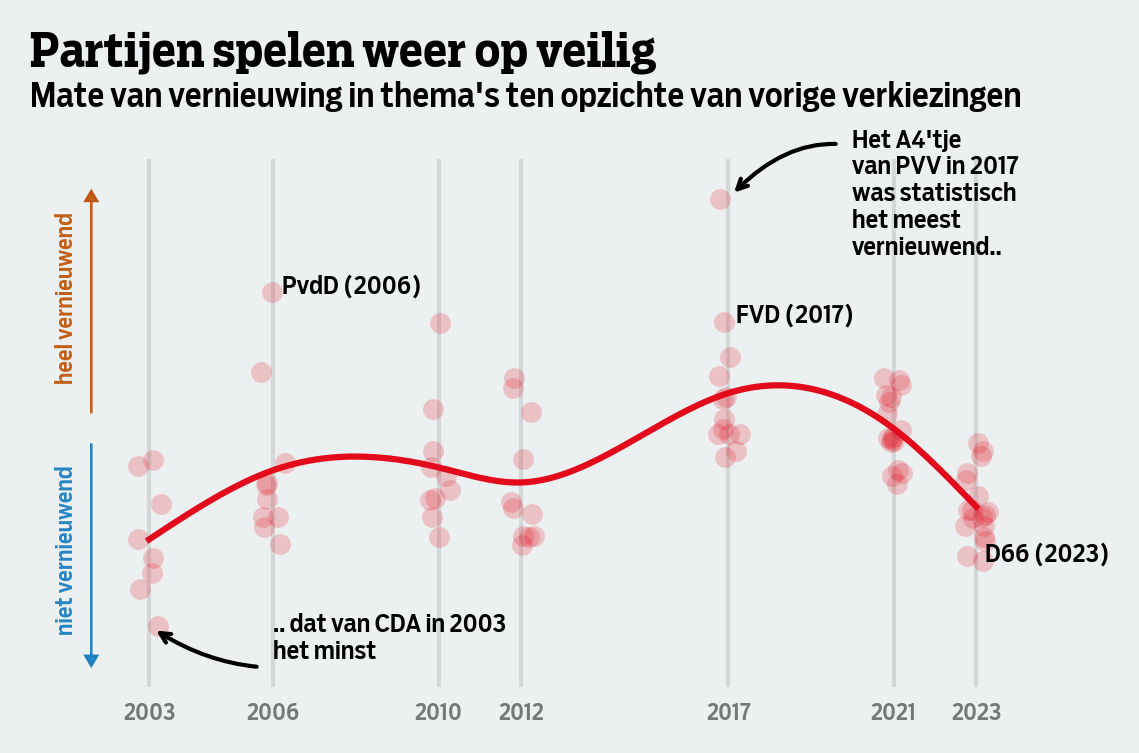

In [5]:
import random

party2col = {
"PvdA": "#e30b1b",
"CDA": "#3c9535",
"VVD": "#ff5501",
"SP": "#c71617",
"D66": "#00b72c",
"GL": "#69ca1f",
"PVV": "#0d4675",
"CU": "#00a0ed",
"SGP": "#f39307",
"PvdD": "#007124",
"Overig": "#7f7b7a",
"DENK": "#BE4F00",
"FVD": "#a81916",
"NSC": "#13123b",
"GL/PvdA": "#00a646",
"BBB": "#92c01f",
"JA21": "#232b57"
}

novelty = pd.DataFrame(results)
novelty['color'] = novelty.party.apply(lambda x: party2col[x] if x in party2col else party2col['Overig'])
novelty = novelty[novelty.seats > 0]

fig, ax = plt.subplots(figsize=(2.53 * 1.5, 2.), dpi=150)
plt.scatter([x + (random.randint(-30, 30) / 100) for x in novelty.year],
            novelty.novelty,s=25, # s=novelty.seats * 3
            alpha=0.2, color='#e30b1b', linewidth=0)

plt.ylim(0.2, 0.7)


for row in novelty.sort_values('novelty', ascending=False).head(3)[1:].itertuples():
    plt.text(row.year +0.2, row.novelty, '{} ({})'.format(row.party, row.year), ha='left')
    

    
for row in novelty.sort_values('novelty', ascending=False).tail(4)[:1].itertuples():
    plt.text(row.year +0.2, row.novelty, '{} ({})'.format(row.party, row.year), ha='left')
    
    
grouped_by_year = novelty.groupby('year').mean(numeric_only=True)

plt.plot(*smooth(grouped_by_year.index, grouped_by_year.novelty), alpha=1, color='#e30b1b', label='Gemiddelde')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
ax.xaxis.set_ticklabels([]) 
ax.yaxis.set_ticklabels([])


for year in grouped_by_year.index:
    plt.axvline(year, alpha=0.1, linewidth=1, color='black', zorder=-1)
    plt.text(year, 0.17, year, alpha=0.5, ha='center', fontsize=5.5)

plt.title('Partijen spelen weer op veilig', x=-0.01, fontsize=11, ha='left', y=1.13)
plt.text(-0.01,1.1,"Mate van vernieuwing in thema's ten opzichte van vorige verkiezingen ",
           transform=plt.gca().transAxes, fontsize=8)

plt.annotate(xy=(2017, 0.662484),text= "Het A4\'tje\nvan PVV in 2017\nwas statistisch\nhet meest\nvernieuwend..", 
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.5'), # style of the arrow
             xytext=(2020, 0.61))

plt.annotate(xy=(2003, 0.257954),text= ".. dat van CDA in 2003\nhet minst", 
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-.3', alpha=1), # style of the arrow
             xytext=(2006, 0.227954), alpha=1)



plt.arrow(2001.6, 0.46, 0,0.2,linewidth=0.5, head_width=0.3, head_length=0.01, alpha=0.9, color='#BE4F00')
plt.text(2001.0, 0.65,'heel vernieuwend', fontsize=5.5, rotation=90, ha='center', 
         va='top', alpha=0.9, color='#BE4F00')

plt.arrow(2001.6, 0.43, 0,-0.2, linewidth=0.5, head_width=0.3, head_length=0.01, alpha=0.9, color='#127abf')
plt.text(2001.0, 0.25,'niet vernieuwend', fontsize=5.5, rotation=90, ha='center', 
         va='bottom', alpha=0.9, color='#127abf')

set_size(fig, (2.53 *1.5, 2.5))

plt.savefig('figures/2.png', dpi=300, bbox_inches='tight')
plt.savefig('figures/2.pdf', dpi=300, bbox_inches='tight')